# Modeling fish production, using Stock et al. 2017 equations. 
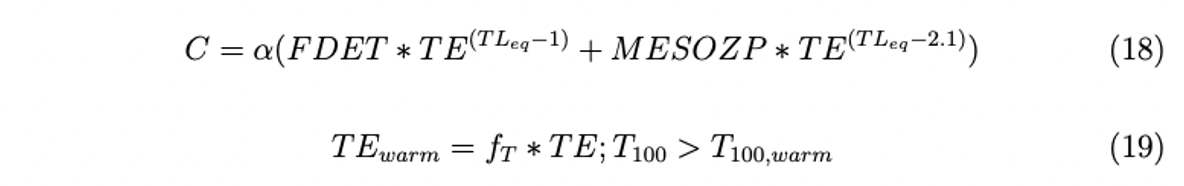

__{$\alpha$}__ = harvesting factor interpreted as the fraction of energy available at TL$_{eq}$ that is realized as catch

* in Stock et al. 2017, single values of TE and $\alpha$  are fit across LMEs such that any interregional variation in these parameters would appear as unexplained catch variance

* __{$\alpha$} was constrained between 0 and 1.__ 

__FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

__TE__ = trophic transfer efficincy, controlling the decay of energy between trophic levels. This is a dimensionless free paramter controlling the decay of energy between trophic levels. 

* __values of TE were constrained within typical observed ranges of 0-0.4__
    * (Pauly D, Christensen V (1995) Primary production required to sustain global fisheries. Nature 374(6519):255–257.)
    * Libralato S, Coll M, Tudela S, Palomera I, Pranovi F (2008) Novel index for quantification of ecosystem effects of fishing as removal of secondary production. Mar Ecol Prog Ser 355:107–129.

__TL$_{eq}$__ = equivalent trophic level of the aggreagte catch derived from FishBase. It scaled by a trophic level of 1 for FDET and 2.1 for MESOZP from the fish catch. 

* Phytoplankton are assigned to trophic level 1, such that TL$_{eq}$ - 1 is the number of trophic steps separating phytoplankton from the fish catch.  

__MESOZP__ = mesozooplankton production not consumed by other zooplankton


In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import xarray as xr
import cartopy.crs as ccrs

import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
import re
import utils

## Interannual data

In [2]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [3]:
variables = [f'{var}' for var in ['POC_FLUX_IN','KMT','photoC_TOT','x_graze_zoo3_zint',
                                 'x_graze_zoo4_zint','x_graze_zoo5_zint','x_graze_zoo6_zint',
                                 'zoo3_linear_loss_zint_100m','zoo4_linear_loss_zint_100m',
                                 'zoo5_linear_loss_zint_100m','zoo6_linear_loss_zint_100m']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [4]:
%%time

ds_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_annual = xr.Dataset()

    file = sorted(glob.glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    dsv_annual=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_annual = xr.merge((ds_annual, dsv_annual[vv]))
        

    ds_annual = ds_annual.drop([v for v in ds_annual.variables if v not in keep_vars]).squeeze()
    ds_annual = ds_annual.sum(dim='time')
    ds_avg = xr.concat([ds_avg, ds_annual],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 9min 1s, sys: 1min 57s, total: 10min 58s
Wall time: 14min 6s


### __FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

In [5]:
flux_bottom = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/flux_bottom_62yr.npy")

In [6]:
flux_bottom_depth = flux_bottom * (60*60*24*365)/100 * 12.011 / 1e3 #g/m^2/y

### total NPP

In [7]:
total_npp = np.nansum(ds_avg.photoC_TOT,axis=1) * 10 # (10 = depth of each layer) integrate over depth mmol/m^3/s to #mmol m-2 s-1
total_npp = total_npp * (60*60*24*365) # mmol m-2 y-1
total_npp = total_npp * 12.011 / 1e3 # g/m^2/y

In [ ]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 400, 20)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=200)
lon, lat, zoo = utils.adjust_pop_grid(dsv_annual.TLONG, dsv_annual.TLAT, np.nanmean(total_npp,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('62 yr avg NPP (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

### Compare FDET/NPP with Stock et al. 2017

In [ ]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 64, 2)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=32)
lon, lat, zoo = utils.adjust_pop_grid(dsv_annual.TLONG, dsv_annual.TLAT, np.nanmean(flux_bottom_depth,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('62 yr avg FDET (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 0.18, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.09)
lon, lat, zoo = utils.adjust_pop_grid(dsv_annual.TLONG, dsv_annual.TLAT, np.nanmean(flux_bottom_depth,axis=0)/np.nanmean(total_npp,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('FDET/NPP', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

### __MESOZP__ = mesozooplankton production not consumed by other zooplankton
* Here, I will use zooplankton production - zooplankton grazing on zooplankton of each category

## sum of Mesozooplankton Grazing Gain Vertical Integral mol/m^3 cm/s

In [8]:
# sum of Mesozooplankton Grazing Gain Vertical Integral mol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds_avg['zooGraz'] = xr.concat([ds_avg['x_graze_' + v + '_zint'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooGraz_TOT = ds_avg.zooGraz *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

## zooplankton Linear loss vertical Intergral mmol/m^3 cm/s

In [9]:
# zooplankton Linear loss vertical Intergral mmol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds_avg['zooLoss'] = xr.concat([ds_avg[''+ v + '_linear_loss_zint_100m'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooloss_TOT = ds_avg.zooLoss *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

### ds.zoo1_linear_loss_zint_100m OR ds.zoo1_linear_loss_zint
* max zoo production with zoo1_linear_loss_zint_100m is 54.58, and min is -1.4
* max zoo production with zoo1_linear_loss_zint is 45.77, and min is -7.14

In [10]:
zooProduction = np.subtract(zooGraz_TOT, zooloss_TOT)
zooProduction_updated = np.where(zooProduction<0, 0, zooProduction)

In [11]:
np.nanmin(zooProduction_updated)

0.0

In [12]:
np.nanmax(zooProduction_updated)

526.7230739772459

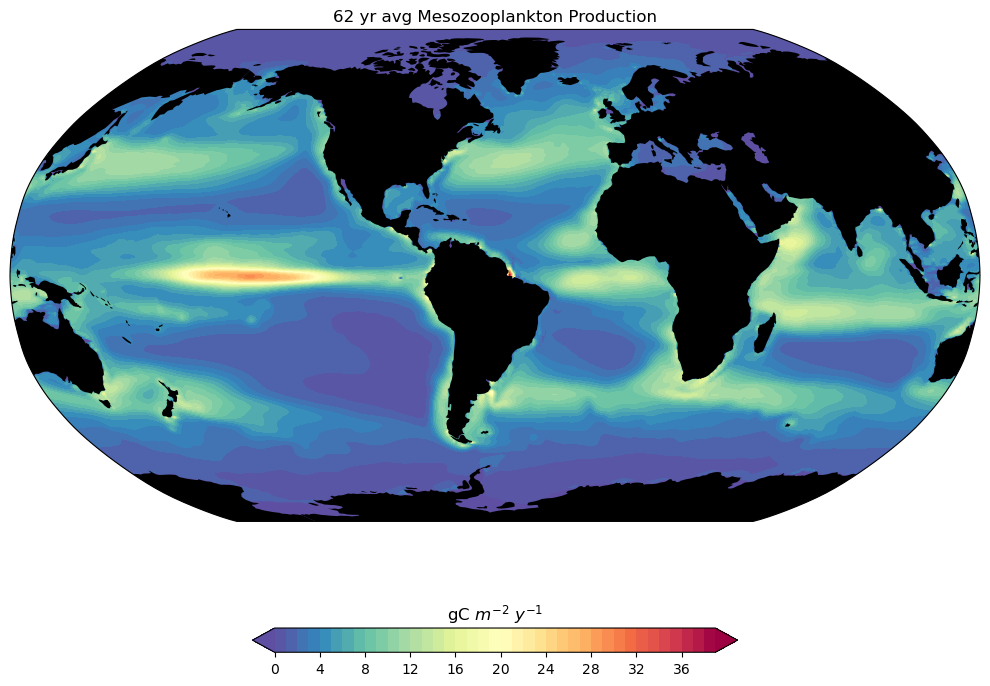

In [16]:
lev = np.arange(0, 40, 1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=20)

fig = plt.figure(figsize=(10, 7.5))
lon, lat, zoo = utils.adjust_pop_grid(dsv_annual.TLONG, dsv_annual.TLAT, np.nanmean(zooProduction_updated,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('gC $m^{-2}$ $y^{-1}$')
ax.set_title('62 yr avg Mesozooplankton Production');
plt.tight_layout()

## Mesozooplankton produciton/ NPP

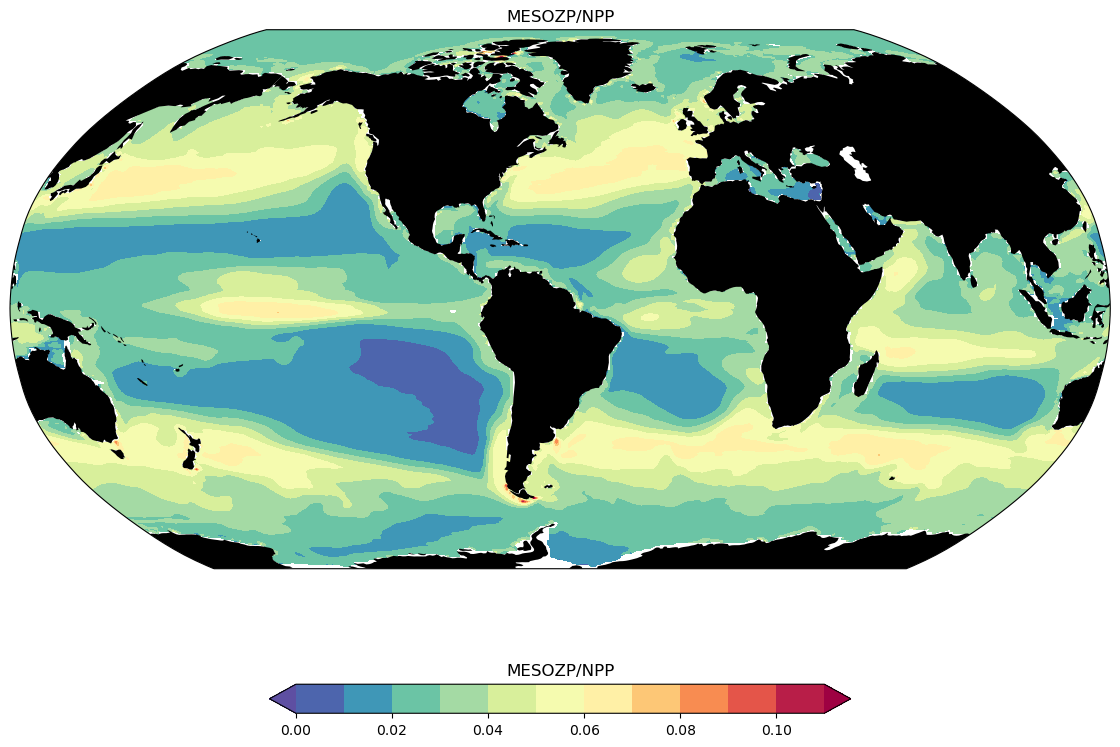

In [17]:
fig = plt.figure(figsize=(15, 10))
lev = np.arange(0, 0.12, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.06)
lon, lat, zoo = utils.adjust_pop_grid(dsv_annual.TLONG, dsv_annual.TLAT, np.nanmean(zooProduction_updated,axis=0)/np.nanmean(total_npp,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('MESOZP/NPP')
ax.set_title('MESOZP/NPP');

### Grazing flux based on trophic level 

In [13]:
ZooTL_g = np.load("/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/mesozoo_TL_62yr.npy") # this might not be the 62 yr avg and instead the 20 yr avg, so I will have to redo this eventually! 

In [14]:
ZooTL_g.shape

(62, 15, 384, 320)

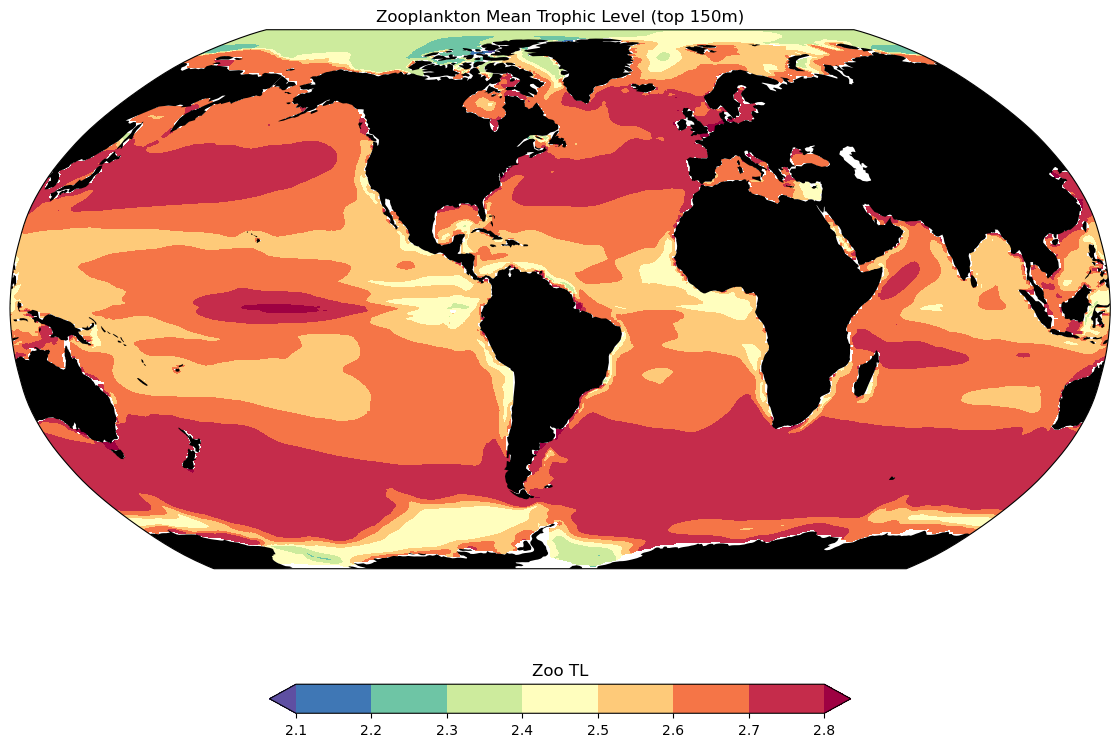

In [20]:
fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = utils.adjust_pop_grid(dsv_annual.TLONG, dsv_annual.TLAT, np.nanmean(ZooTL_g,axis=(0,1)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zoo TL')
ax.set_title('Zooplankton Mean Trophic Level (top 150m)');

### Calculating Fish Production

## Calculate the fish production for every year... 

In [15]:
alpha = 1 # ranges from 0 to 1 
FDET = flux_bottom_depth # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 4 # trophic level (np.nanmean(ZooTL_g,axis=(0,1,2,3))) ---> (2.5885172746837832)
MESOZP =  zooProduction_updated # g C / m^2 s
TL = np.nanmean(ZooTL_g,axis=(1,2,3))

pelagic = np.empty([62,384,320]) # Size of the array that I need
pelagic[:] = np.nan # make everything a nan inside of it

benthic = np.empty([62,384,320]) # Size of the array that I need
benthic[:] = np.nan # make everything a nan inside of it

for i in range(62):
### 1. Pelagic Fish Production 
    pelagic[i,:,:] = (MESOZP[i,:,:]*TE**(TE_eq-TL[i]))
### 2. Benthic Fish Production 
    benthic[i,:,:] = (FDET[i,:,:]*TE**(TE_eq-1))

## Benthic/Pelagic
ratio = benthic/pelagic

In [16]:
%%time
np.save("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/fish_production_benthic_62yr_TL4.npy", benthic)
np.save("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/fish_production_pelagic_62yr_TL4.npy", pelagic)

CPU times: user 385 µs, sys: 36.1 ms, total: 36.5 ms
Wall time: 117 ms


#### Now make a plot with three pannels:
    1. Flux Production (Benthic Flux)
    2. Pelagic Fish Production 
    3. FDET Flux/Pelagic 